# Introduction

This notebook compares some estimators against simulated AB test results.

# Setup

In [1]:
%%capture
%cd ..

# Libraries

In [2]:
from src import simulation
from src import estimators

In [3]:
import numpy as np

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Data

Create a log of $1,000$ records:

In [5]:
logs = simulation.create_logs(n=1000)
logs.head(5)

,user_features,ad_placed,ad_prob,ad_revenue,model_prob,ab_test_revenue
0,user3,product_c,0.142857,0,0.30,120
1,user3,product_g,0.142857,160,0.06,120
2,user2,product_g,0.142857,0,0.10,200
3,user2,product_e,0.142857,500,0.30,500
4,user2,product_f,0.142857,0,0.10,200


A production log would look like the following:

In [6]:
logs[["user_features", "ad_placed", "ad_prob", "ad_revenue"]].sample(n=10)

,user_features,ad_placed,ad_prob,ad_revenue
875,user3,product_g,0.142857,160
487,user1,product_f,0.142857,0
618,user2,product_g,0.142857,0
935,user1,product_g,0.142857,0
302,user3,product_f,0.142857,120
699,user1,product_a,0.142857,100
48,user3,product_d,0.142857,0
129,user1,product_g,0.142857,0
111,user2,product_d,0.142857,200
152,user2,product_g,0.142857,0


# Policy Expected Reward

In [7]:
%%time
sim = simulation.create_logs(n=1000000)
logging_policy = sim["ad_revenue"].mean()
target_policy = sim["ab_test_revenue"].mean()

print(f"Expected reward from logging policy: {logging_policy: .2f}")
print(f"Expected reward from target policy: {target_policy: .2f}")

Expected reward from logging policy:  63.30
Expected reward from target policy:  100.99
CPU times: user 2min 1s, sys: 4.83 s, total: 2min 6s
Wall time: 2min


# Estimators

Reward from logs:

In [8]:
logs["ad_revenue"].mean()

63.43

Reward using IPS estimator:

In [9]:
ips_est = estimators.compute_ips(logs)
ips_est

103.45859999999992

Reward using NCIS estimator:

In [10]:
ncis_est = estimators.compute_ncis(logs, cap=1000)
ncis_est

102.64462809917339

# Estimator Convergence

In [11]:
def compute_estimator(logsize, runs=1):
    ab_test = []
    ips = []
    ncis_05 = []
    ncis_1 = []
    ncis_2 = []
    
    for _ in range(runs):
        sim = simulation.create_logs(logsize)
        
        ab_test.append(sim["ab_test_revenue"].mean())
        ips.append(estimators.compute_ips(sim))
        ncis_05.append(estimators.compute_ncis(sim, cap=0.5))
        ncis_1.append(estimators.compute_ncis(sim, cap=1))
        ncis_2.append(estimators.compute_ncis(sim, cap=2))
    
    return np.mean(ab_test), np.mean(ips), np.mean(ncis_05), np.mean(ncis_1), np.mean(ncis_2)

In [12]:
%%time
xs = list(range(10, 10010, 90))
ab_test, ips, ncis_05, ncis_1, ncis_2 = zip(*[compute_estimator(x) for x in xs])

CPU times: user 1min 14s, sys: 2.17 s, total: 1min 16s
Wall time: 1min 13s


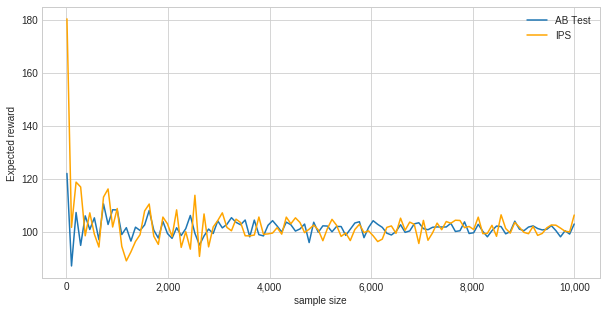

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes()

ax.plot(xs, ab_test, label="AB Test", color="C0")
ax.plot(xs, ips, label="IPS", color="orange")
ax.legend()

ax.set(xlabel="sample size",
       ylabel="Expected reward")

ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

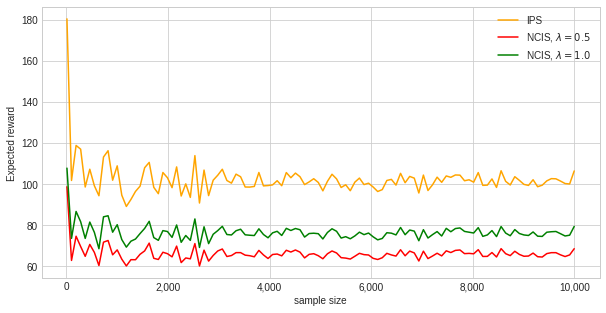

In [14]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes()

ax.plot(xs, ips, label="IPS", color="orange")
ax.plot(xs, ncis_05, label="NCIS, $\lambda=0.5$", color="red")
ax.plot(xs, ncis_1, label="NCIS, $\lambda=1.0$", color="green")
# ax.plot(xs, ncis_2, label="NCIS, $\lambda=2.0$")
ax.legend()

ax.set(xlabel="sample size",
       ylabel="Expected reward")

ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))